# Getting started with `pymc3`
In this notebook, we will try to get started with the [`pymc3` package for Bayesian statistics in python](https://docs.pymc.io/). We will do as recommended and begin by implementing a linear regression model, predicting outcomes $Y$ as normally-distributed observations with an expected value $\mu$ that is a linear combination of two cofactors, $X_1$ and $X_2$. The model is
\begin{align}
  Y &\sim \mathcal{N} (\mu, \, \sigma^2), \\
  \mu &= \alpha + \beta_1 X_1 + \beta_2 X_2.
\end{align}

First, we generate some data:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

This is what our generated data look like:

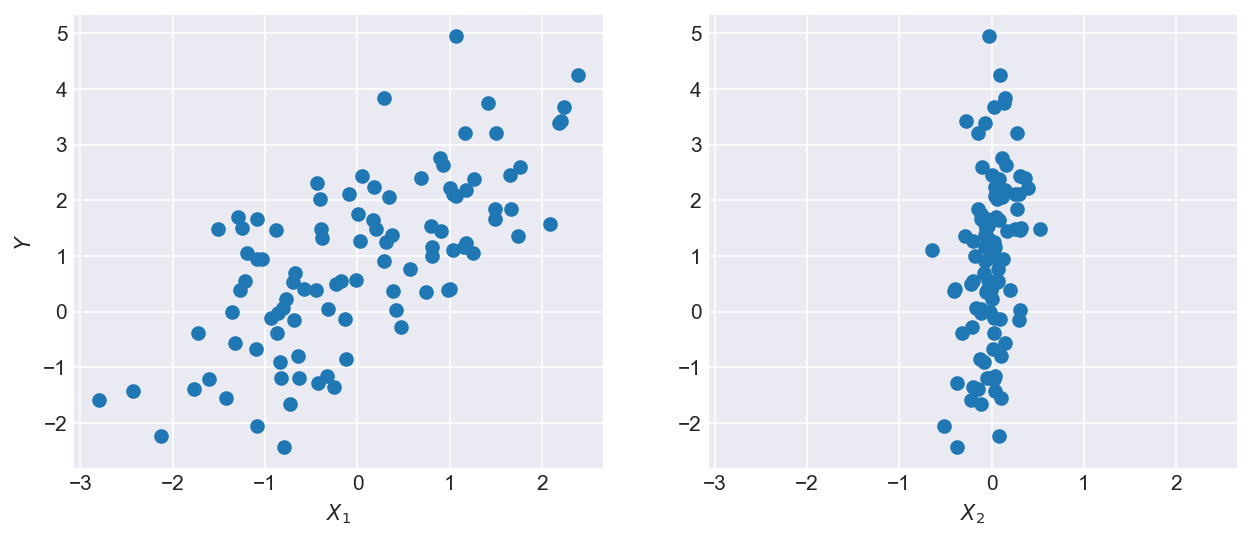

In [2]:
%matplotlib inline

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4), dpi=150)
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel(r'$Y$'); axes[0].set_xlabel(r'$X_1$'); axes[1].set_xlabel(r'$X_2$');

In order to "guess" the model in a Bayesian framework, we need to specify initial distributions for the different variables. We will assume we know next to nothing about the paramaters, and use the following:
\begin{align}
  \alpha &\sim \mathcal{N}(0, 100) \\
  \beta_i &\sim \mathcal{N}(0, 100) \\
  \sigma &\sim |\mathcal{N}(0, 1)| \\
\end{align}

The next step is specifying the model in `pymc3`. It is conventional to import the package as `pm`.

In [3]:
import pymc3 as pm
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.7


Next, we build the model line by line:

In [10]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

## Model fitting
We will now try two different methods of model fitting: The **maximum a posteriori** and **Markov Chain Monte Carlo** methods.

### Maximum a posteriori (MAP)
The MAP method basicsally turns the problem into an optimization problem, and then uses some numerical algorithm for solving the problem with respect to the given paramers. The standard algorithm is the BFGS algorithm, a quasi-Newton method.

In [5]:
map_estimate = pm.find_MAP(model=basic_model); map_estimate

/Users/erikaja/anaconda3/envs/pymc3test/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -149.58, ||grad|| = 12.242: 100%|██████████| 19/19 [00:00<00:00, 901.28it/s]  


{'alpha': array(0.90660093),
 'beta': array([0.94848596, 2.60711845]),
 'sigma_log__': array(-0.03771373),
 'sigma': array(0.96298858)}

A weakness of this approach is that we are only given point estimates. There are also the problems associated with numerical optimization in general, namely that we are likely to only find a _local_ minimum. This is often good enough, but not always.

### Sampling methods
To conduct MCMC sampling to generate posterior samples, wae need to specify a particular MCMC algorithm through the `step` parameter; alternatively, PyMC3 will do it automatically. Often, it is easier to just leave it as-is, and PyMC3 will select recommended methods based on each parameter's sample space, as well as initializing each algorithm with what it deems to be suitable values for any hyperparameters (based on the provided data).

In [11]:
with basic_model:
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:01<00:00, 2553.48draws/s]


## Posterior analysis

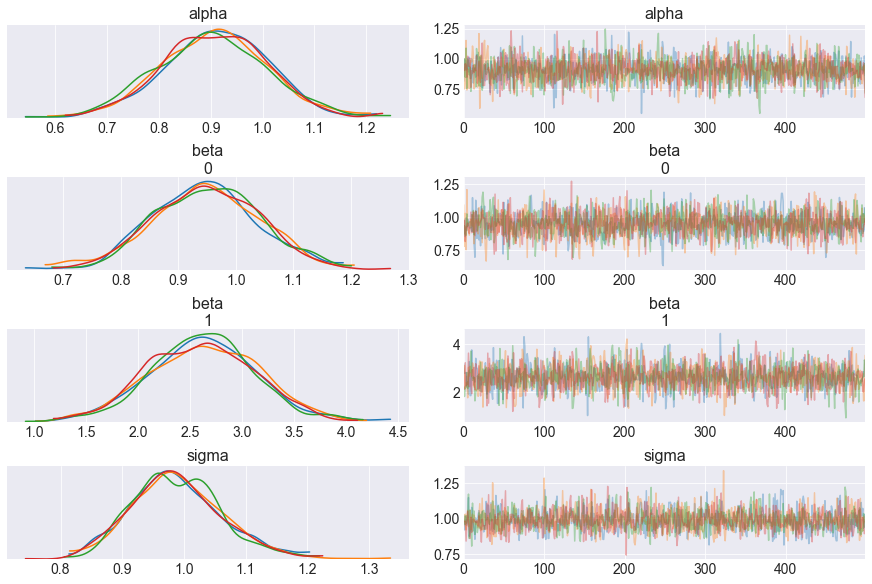

In [8]:
pm.traceplot(trace);

We can also plot summary statistics:

In [9]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.91,0.10,0.00,0.72,1.11,2898.01,1.0
beta__0,0.95,0.09,0.00,0.78,1.14,3219.72,1.0
beta__1,2.62,0.51,0.01,1.57,3.61,2470.17,1.0
sigma,0.99,0.07,0.00,0.84,1.13,2697.41,1.0
